In [1]:
import joblib
import pandas as pd
import numpy as np
from wordcloud import WordCloud

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [2]:
df_test = pd.read_csv("../../../data/mixed_dataset/test_cleaned.csv", index_col=0)
df_test = df_test[df_test.tweet_cleaned.notna()]

In [3]:
df_test = df_test[["label", "tweet", "tweet_cleaned"]]

#### Detaillierte Modellbetrachtung

Frage: welche Tweets können nicht korrekt vorhergesagt werden?

In [4]:
def create_proba_df(model, vectorizer, data, column_name):
    x_data = data[column_name]
    y_data = data.label

    predictions = model.predict(vectorizer.transform(x_data))
    false_predictions = np.logical_not(np.equal(y_data, predictions))
    false_preds_df = data[false_predictions]

    false_tweets_vec = vectorizer.transform(false_preds_df[column_name])
    proba_false = model.predict_proba(false_tweets_vec)

    false_preds_df["zero_proba"] = proba_false[:, 0]
    false_preds_df["one_proba"] = proba_false[:, 1]
    false_preds_df["pred"] = model.predict(false_tweets_vec)

    return false_preds_df

In [5]:
def print_roc_auc(model, vectorizer, data, column_name):
    x_data = data[column_name]
    y_data = data.label
    predictions = model.predict(vectorizer.transform(x_data))

    # Compute fpr, tpr, thresholds and roc auc
    fpr, tpr, thresholds = roc_curve(y_data, predictions)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

##### Betrachtung BalancedRandomForest

In [6]:
loaded_tfidf_vectorizer = joblib.load("evaluation/tfidf_vectorizer.joblib")
loaded_brf = joblib.load("evaluation/tfidf_balancedrandomforest.joblib")

In [7]:
df_false_classifications_brf = create_proba_df(loaded_brf, loaded_tfidf_vectorizer, df_test, "tweet_cleaned")

In [8]:
df_false_classifications_brf.groupby(df_false_classifications_brf.label).count()

,tweet,tweet_cleaned,zero_proba,one_proba,pred
label,,,,,
0,5169,5169,5169,5169,5169
1,2097,2097,2097,2097,2097


In [9]:
df_false_classifications_brf.head()

,label,tweet,tweet_cleaned,zero_proba,one_proba,pred
16763,0,i didn't know crowder was such an ass...,know crowder ass,0.4225,0.5775,1
26538,1,@user there's never any room for in a school ...,never room school board ever kid school future,0.7000,0.3000,0
13046,0,oh gosh. this freaking killed me&gt;&gt; not ...,oh gosh freaking kill president,0.3500,0.6500,1
12084,0,politics is great in theory but politicians ar...,politic great theory politician self obsess po...,0.4600,0.5400,1
24456,1,@user how do you sleep at night? you are a te...,sleep night terrible person sir represent ever...,0.8300,0.1700,0


In [10]:
df_false_classifications_brf[df_false_classifications_brf.label == 1]

,label,tweet,tweet_cleaned,zero_proba,one_proba,pred
26538,1,@user there's never any room for in a school ...,never room school board ever kid school future,0.700,0.300,0
24456,1,@user how do you sleep at night? you are a te...,sleep night terrible person sir represent ever...,0.830,0.170,0
168,1,@user @user you point one finger @user million...,point one finger million point right back,0.540,0.460,0
17709,1,@user #feminismiscancer #feminismisterrorism #...,ignore,0.570,0.430,0
2294,1,@user @user yes disgusting and hateful #trumps...,yes disgusting hateful hateful,0.610,0.390,0
...,...,...,...,...,...,...
175804,1,@user @user Do you think that he is Jewish any...,think jewish way birth,0.570,0.430,0
175889,1,I need my cock gwazed wike a donut with a woma...,need cock womans pussy want cock put baby want...,0.620,0.380,0
175892,1,I bet you love watching all your aryan brother...,bet love watch aryan brother shoot mexicans huh,0.780,0.220,0
176007,1,Fucking the bitch is one thing but you let thi...,fucking bitch one thing let hoe use toothbrush...,0.615,0.385,0


##### Betrachtung CatBoostClassifier

In [11]:
loaded_cat = joblib.load("evaluation/tfidf_catboostclassifier.joblib")

In [12]:
df_false_classifications_cat = create_proba_df(loaded_cat, loaded_tfidf_vectorizer, df_test, "tweet_cleaned")

In [13]:
df_false_classifications_cat.groupby(df_false_classifications_cat.label).count()

,tweet,tweet_cleaned,zero_proba,one_proba,pred
label,,,,,
0,4831,4831,4831,4831,4831
1,2223,2223,2223,2223,2223


In [14]:
df_false_classifications_cat.head()

,label,tweet,tweet_cleaned,zero_proba,one_proba,pred
6640,1,and #misogyny is alive and well on the #left....,misogyny alive well left never let tell,0.692839,0.307161,0
26538,1,@user there's never any room for in a school ...,never room school board ever kid school future,0.895704,0.104296,0
13046,0,oh gosh. this freaking killed me&gt;&gt; not ...,oh gosh freaking kill president,0.378784,0.621216,1
24456,1,@user how do you sleep at night? you are a te...,sleep night terrible person sir represent ever...,0.757171,0.242829,0
16228,1,@user #kkk+#blm = same #nazi #scum from #hitle...,= nazi scum different color skin leftist = dem...,0.511305,0.488695,0


In [15]:
df_false_classifications_cat[df_false_classifications_cat.label == 1]

,label,tweet,tweet_cleaned,zero_proba,one_proba,pred
6640,1,and #misogyny is alive and well on the #left....,misogyny alive well left never let tell,0.692839,0.307161,0
26538,1,@user there's never any room for in a school ...,never room school board ever kid school future,0.895704,0.104296,0
24456,1,@user how do you sleep at night? you are a te...,sleep night terrible person sir represent ever...,0.757171,0.242829,0
16228,1,@user #kkk+#blm = same #nazi #scum from #hitle...,= nazi scum different color skin leftist = dem...,0.511305,0.488695,0
25917,1,book - #german #colonialism in a global age h...,book - german colonialism global age ht imperi...,0.687356,0.312644,0
...,...,...,...,...,...,...
175889,1,I need my cock gwazed wike a donut with a woma...,need cock womans pussy want cock put baby want...,0.725550,0.274450,0
175892,1,I bet you love watching all your aryan brother...,bet love watch aryan brother shoot mexicans huh,0.842284,0.157716,0
176007,1,Fucking the bitch is one thing but you let thi...,fucking bitch one thing let hoe use toothbrush...,0.508212,0.491788,0
176224,1,"Another subreddit, same outcome. You are a bea...",another subreddit outcome beautiful woman need...,0.752005,0.247995,0


##### Fusionierung

In [16]:
merged_false = pd.merge(df_false_classifications_brf, df_false_classifications_cat, on=['tweet_cleaned'])

In [17]:
merged_false.rename(columns={
    'label_x': 'label',
    'tweet_x': 'tweet',
    'zero_proba_x': 'zero_proba_brf',
    'one_proba_x': 'one_proba_brf',
    'zero_proba_y': 'zero_proba_cat',
    'one_proba_y': 'one_proba_cat',
    'pred_x': 'pred_brf',
    'pred_y': 'pred_cat'}, inplace=True)

In [18]:
merged_false

,label,tweet,tweet_cleaned,zero_proba_brf,one_proba_brf,pred_brf,label_y,tweet_y,zero_proba_cat,one_proba_cat,pred_cat
0,1,@user there's never any room for in a school ...,never room school board ever kid school future,0.70,0.30,0,1,@user there's never any room for in a school ...,0.895704,0.104296,0
1,0,oh gosh. this freaking killed me&gt;&gt; not ...,oh gosh freaking kill president,0.35,0.65,1,0,oh gosh. this freaking killed me&gt;&gt; not ...,0.378784,0.621216,1
2,1,@user how do you sleep at night? you are a te...,sleep night terrible person sir represent ever...,0.83,0.17,0,1,@user how do you sleep at night? you are a te...,0.757171,0.242829,0
3,1,@user @user you point one finger @user million...,point one finger million point right back,0.54,0.46,0,1,@user @user you point one finger @user million...,0.705957,0.294043,0
4,0,.@user @user voters like him not for his polic...,voter like policy racism omg,0.44,0.56,1,0,.@user @user voters like him not for his polic...,0.338501,0.661499,1
...,...,...,...,...,...,...,...,...,...,...,...
5527,0,"Well, women deserve to be murdered. Incels sho...",well woman deserve murder incel never conseque...,0.17,0.83,1,0,"Well, women deserve to be murdered. Incels sho...",0.057650,0.942350,1
5528,1,"Another subreddit, same outcome. You are a bea...",another subreddit outcome beautiful woman need...,0.81,0.19,0,1,"Another subreddit, same outcome. You are a bea...",0.752005,0.247995,0
5529,0,All my white school teachers back in elementar...,white school teacher back elementary know give...,0.28,0.72,1,0,All my white school teachers back in elementar...,0.393873,0.606127,1
5530,0,Kill religion then and there.,kill religion,0.43,0.57,1,0,Kill religion then and there.,0.436556,0.563444,1


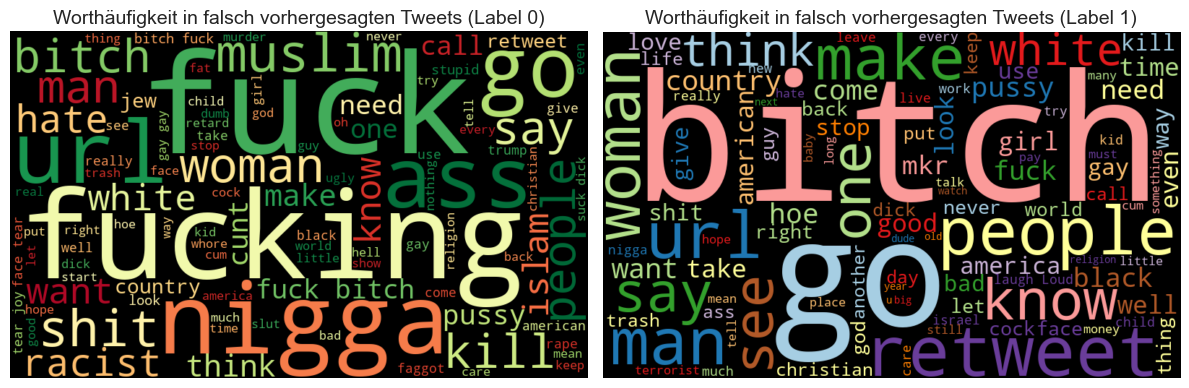

In [19]:
# dataset_1_text = " ".join(df_origin["tweet"].tolist())

dataset_0_text = " ".join(merged_false[merged_false.label == 0]["tweet_cleaned"].tolist())
dataset_1_text = " ".join(merged_false[merged_false.label == 1]["tweet_cleaned"].tolist())

plt.figure(figsize=(12, 6))

# Subplot 1: Dataset 0
plt.subplot(1, 2, 1)
wordcloud = WordCloud(stopwords=None, width=800, height=480, max_words=100, colormap='RdYlGn').generate(dataset_0_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Worthäufigkeit in falsch vorhergesagten Tweets (Label 0)", fontsize=14)

# Subplot 2: Dataset 1
plt.subplot(1, 2, 2)
wordcloud = WordCloud(stopwords=None, width=800, height=480, max_words=100, colormap='Paired').generate(dataset_1_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Worthäufigkeit in falsch vorhergesagten Tweets (Label 1)", fontsize=14)


plt.tight_layout()
plt.show()

Beschreibung Wordclouds
- links: zeigt die Worthäufigkeiten von falsch vorhergesagten Tweets mit Label 0 (d.h., die Modelle haben 1 vorhergesagt)
    - es sind Schlagworte zu erkennen, die auch häufig in Tweets mit Hate Speech vorkommen ("nigga", häufiger Bezug zu Muslimen/Islam "muslim"/"islam" oder Frauen "women")
- rechts: zeigt die Worthäufigkeiten von falsch vorhergesagten Tweets mit Label 1 (d.h., die Modelle haben 0 vorhergesagt)
    - es sind nicht unbedingt die Schlagworte zu erkennen, die in Hate Speech Tweets vorkommen

Erkenntnisse
- Prüfung von einigen Tweets mit Label 1, welche nicht als 1 vorhergesagt wurden: sehr häufig kein Hate-Speech erkennbar => bedeutet, dass Modelle "richtig" vorhersagen und die Daten schlecht/falsch gelabelt sind
- Prüfung von einigen Tweets mit Label 0, welche nicht als 0 vorhergesagt wurden: enthalten Schlagworte, die auf Hate-Speech hindeuten